# King County Housing Price Analysis

## Experiment Design
1. In order to experiment with different models and variantions, we should define what's the overall process
2. For this project, we focus on the following meta steps which can be flexiably replaced with different concrete variations of models
    * Divide data into trainingAndValidation and test via the same seed so that results are comparable across different       models
    * Dataframe level preprocessing: adding new columns, apply udfs, drop rows, drop columns and etc.
    * Apply necessary feature transformation (standardization, PCA, remove outliers or etc)
    * Actual model to be used 
    * Prepare CV data for hyper parameter tuning
    * Use the best model on test data and create final summary 
3. Note that, since we focused on two very different genres of models: linear regression v.s. Tree Basd Regressor. So we keep the evaluation in a free format instead of specific type. For example, $R^2$ should not be used for non linear models


## Overview of this code and review guide
In order to provide a smooth experience for TA and Professor Acuna, we breifly explain the structure of this notebook
1. Boilerplates setting up: here we set up the common code shared by multiple tasks
2. Models: 
    * For each model we need to impelement the two **high level** functions: model_func and evaluate_func which contain the detiled logics of training and evaluation. Also an optional function df_func can be provided to do preprocessing before training or evaluation
    * For each model, we will give a very brief summary of our observation
3. Comparison: we should include a short summary of the performances for different models
4. Appendix script for analysis and exploration: here we can add some additional results of data visulization and analysis.

# I. boilerplates

In [2]:
# Suppress annoying warnings from numpy
import warnings
warnings.filterwarnings('ignore')
# spark related imports
from pyspark.sql import SparkSession, functions as fn, Row
from pyspark.ml import feature, regression, Pipeline
from pyspark import sql
# python related libs for data analysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import udf, array
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.functions import datediff, to_date, lit
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import Normalizer, StandardScaler
from datetime import datetime
from math import sin, cos, sqrt, atan2, radians,log
from pyspark.ml.regression import GeneralizedLinearRegression

# The overall runner for all experiments
def process(entireData, model_func, evaluate_func, df_func=None, tnv=0.9, test=0.1):
    data = entireData if df_func is None else df_func(entireData)
    trainAndVal, test = data.randomSplit([tnv, test], seed=0)
    trainAndVal.persist()
    test.persist()
    model = model_func(trainAndVal)
    evaluate_func(model, test)
    trainAndVal.unpersist()
    test.unpersist()
    
# setup spark session read the raw data in 
spark = SparkSession.builder.getOrCreate()
raw_df = spark.createDataFrame(pd.read_csv(
    './kc_house_data.csv',
    sep=',',
    header=0))

In [3]:
Tdata=[(50000, 3, 1, 400,5000,3.0,1,1,2,4,460,0,1150,5000,0.888,1.888,0.555,0.24444,0.6666,0.4444,4,102,2014)]

In [4]:
Tdf = spark.createDataFrame(Tdata, schema=['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot15',
 'dennyBlaine',
 'laurelhurst',
 'madisonPark',
 'seattle',
 'microsoft',
 'amazon',
 'soldTillNow',
 'builtTillSold',
 'renoTillSold'])

### a. Feature Engineering & Preprocessing
In this section, we focused on some necessary preprocessing and feature engineering 
before moving to data exploration and transformation. The following encompasses a list of new fields
1. distanceToX, instead of directly using latitude and longitude as features, we calculate the distance from the house to a predefined location X. This location can be the center of a famous neighborhood, or the results of kmeans centroid. We'll make this easy to extend for model iteration
2. Preprocessing time/dates. In this data, we have 3 dates
    **year built**, **year renovated**, **date** (sold date). 
  We use this year 2019 as a reference to calculate the diff betwen 2019 and the above dates respectively.

In [5]:
# some necessary UDFs for feature engineering
## 1. a udf factory to create the distance to a specific location (i.e., a center of a town) 
def getDistance(lat, long):
    return udf(lambda arr: getGeoDis(arr[0], arr[1], lat, long), DoubleType())
## 2. a udf factory to calculate the days difference
def getYearDiff(a, b):
    if type(a) is str:
        print(a)
        a = int(a[:4])
    if type(b) is str:
        b = int(b[:4])
    return abs(a-b)

def getGeoDis(lat1, lon1, lat2, lon2):
    R = 6373.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# The distance to top 3 richest neighborhood
dennyBlaine = getDistance(47.61236, -122.29947)
laurelhurst = getDistance(45.5262, -122.6239)
madisonPark = getDistance(47.6346, -122.2796)
seattle = getDistance(47.6050, -122.3344)

# The distance to top 2 companies
microsoft = getDistance(47.6740, -122.1215)
amazon = getDistance(47.6062, -122.3321)

# Calculate two dates difference in years
yearDiff = udf(getYearDiff, IntegerType())

def dfCleaning(raw_df):
    return (raw_df
    .withColumn('dennyBlaine', dennyBlaine(array('lat', 'long')))
    .withColumn('laurelhurst', laurelhurst(array('lat', 'long')))
    .withColumn('madisonPark', madisonPark(array('lat', 'long')))
    .withColumn('seattle', seattle(array('lat', 'long')))
    .withColumn('microsoft', microsoft(array('lat', 'long')))
    .withColumn('amazon', amazon(array('lat', 'long')))
    # years diff
    .withColumn('soldTillNow',yearDiff('date', lit(2019)))
    .withColumn('builtTillSold',yearDiff('date', 'yr_built'))
    .withColumn('renoTillSold', yearDiff('date', 'yr_renovated')))

In [6]:
raw_df.persist()

DataFrame[id: bigint, date: string, price: double, bedrooms: bigint, bathrooms: double, sqft_living: bigint, sqft_lot: bigint, floors: double, waterfront: bigint, view: bigint, condition: bigint, grade: bigint, sqft_above: bigint, sqft_basement: bigint, yr_built: bigint, yr_renovated: bigint, zipcode: bigint, lat: double, long: double, sqft_living15: bigint, sqft_lot15: bigint]

## Naive model 1: without any transformation and pretty much just use data as it is

In [7]:
def naiveModel(trainAndValid, doReg):
    '''
    In naive model, we don't do any feature transformation and only drop columns that's not usable
    '''
    cols = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade',
        'sqft_above','sqft_basement','yr_built','yr_renovated','zipcode','lat','long','sqft_living15','sqft_lot15']
    lr = regression.LinearRegression(maxIter=10, labelCol='price', featuresCol='features')
    pipeline = Pipeline(stages=[
        feature.VectorAssembler(inputCols=cols, outputCol='features'),
        lr
    ])

    paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [1000, 100, 10, 1, 0.1, 0.0] if doReg  else [0.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.3, 0.6, 1.0])\
    .build()
    
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol='price', metricName='rmse'),
                          numFolds=4)  # use 3+ folds in practice

    # Run cross-validation, and choose the best set of parameters.
    return crossval.fit(trainAndValid)


def evaluate(model, test):
    # Note that this only works for cv piped model
    predictions = model.transform(test)
    lrModel = model.bestModel.stages[-1]._java_obj
    print('reg (lambda) parameter: {}'.format(lrModel.getRegParam()))
    print('elastic net (alpha) parameter: {}'.format(lrModel.getElasticNetParam()))
    eval_rmse = RegressionEvaluator(labelCol='price', predictionCol="prediction", metricName="rmse")
    eval_r2 = RegressionEvaluator(labelCol='price', predictionCol="prediction", metricName="r2")
    eval_mae = RegressionEvaluator(labelCol='price', predictionCol="prediction", metricName="mae")
    print('RMSE: {}'.format(eval_rmse.evaluate(predictions))) 
    print('R2: {}'.format(eval_r2.evaluate(predictions)))
    print('MAE: {}'.format(eval_mae.evaluate(predictions)))

## Naive model 2: add some basic transformations and use standardization

In [8]:
def modelWithFE(trainAndValid, doReg):
    '''
    In naive model 2, we perform basic feature transformation and standardization
    '''
    # adding parantheses for easier line changing
    
    columns_of_interests = [
    'soldTillNow', 'builtTillSold', 'renoTillSold', 
    'dennyBlaine', 'laurelhurst', 'madisonPark', 'seattle', 'microsoft', 'amazon',
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','sqft_above', 'sqft_basement',
    'sqft_living15', 'sqft_lot15', 
    'waterfront', 'view', 'condition', 'grade']
    
    lr = regression.LinearRegression(maxIter=80, labelCol='price', featuresCol='scaledFeatures')
    pipeline = Pipeline(stages=[
        feature.VectorAssembler(inputCols=columns_of_interests, outputCol='features'),
        StandardScaler(inputCol = "features", outputCol='scaledFeatures'),
        lr
        ])
    paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [1000, 100, 10, 1, 0.1, 0.0] if doReg  else [0.0])\
    .addGrid(lr.elasticNetParam, [0.0, 0.3, 0.6, 1.0])\
    .build()
    
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol='price', metricName='rmse'),
                          numFolds=4)  # use 3+ folds in practice

    # Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(trainAndValid)
    return cvModel

## 3. Adding PCA to reduce dimensions and still train with LR model

In [9]:
def naivePCA(trainAndValid, k):
    '''
    In naive model 3, we build on top of model 2 and see whether PCA is providing extra benefits
    '''
    # adding parantheses for easier line changing
    
    columns_of_interests = [
    'soldTillNow', 'builtTillSold', 'renoTillSold', 
    'dennyBlaine', 'laurelhurst', 'madisonPark', 'seattle', 'microsoft', 'amazon',
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','sqft_above', 'sqft_basement',
    'sqft_living15', 'sqft_lot15', 
    'waterfront', 'view', 'condition', 'grade']
  
    lr = regression.LinearRegression(maxIter=80, labelCol='price', featuresCol='loadings')
    pca =   feature.PCA(k=k, inputCol='scaledFeatures', outputCol='loadings')
    pipeline = Pipeline(stages=[
        feature.VectorAssembler(inputCols=columns_of_interests, outputCol='features'),
        StandardScaler(withMean=True, inputCol = "features", outputCol='scaledFeatures'),
        pca,
        lr
        ])
    
    paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [1000, 100, 10, 1, 0.1, 0.0])\
    .addGrid(lr.elasticNetParam, [0.0, 0.3, 0.6, 1.0])\
    .build()
    
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol='price', metricName='rmse'),
                          numFolds=4)  # use 3+ folds in practice

    # Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(trainAndValid)
    return cvModel

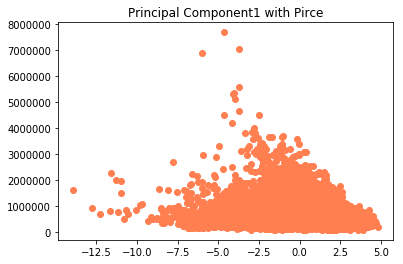

In [10]:
# This part, we just focus on PCA and understand the relation of top components with price to justify our hypothese
def pcaExplore(raw_df):
    data = dfCleaning(raw_df)
    cols = [
    'soldTillNow', 'builtTillSold', 'renoTillSold', 
    'dennyBlaine', 'laurelhurst', 'madisonPark', 'seattle', 'microsoft', 'amazon',
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','sqft_above', 'sqft_basement',
    'sqft_living15', 'sqft_lot15', 
    'waterfront', 'view', 'condition', 'grade']
    
    pipe = Pipeline(stages=[
        feature.VectorAssembler(inputCols=cols, outputCol='features'),
        StandardScaler(withMean=True, inputCol = "features", outputCol='scaledFeatures'),
        feature.PCA(k=20, inputCol='scaledFeatures', outputCol='loadings')
        ]).fit(data)
    
    principal_components = pipe.stages[-1].pc.toArray()
    # Getting top 2 components eigenvalues
    scores = list(zip(cols, 
         principal_components[:, 0], principal_components[:, 1]))
    
    localDF = pipe.transform(data).toPandas()
    
    # exporting to local for easier plotting 
    return localDF, scores

def exploreRelations(df):
    pc1 = []
    price = []
    for i in range(df.shape[0]):
        pc1.append(df['loadings'][i][0])
        price.append(df['price'][i])
    plt.scatter(pc1, price, color = 'coral')
    plt.title('Principal Component1 with Pirce')
    
localDF, scores = pcaExplore(raw_df)
exploreRelations(localDF)

We can see from the plot here that the most important component is not very linear related with price. So PCA is not very useful for linear regression because the variance of label is not directly related to how much variance components can explain in feature space

## 4. Generalized Linear Model

In [11]:
def glm(trainAndValid, doReg):
    '''
    In naive model 4, we build on top of 2 but use Generalized Linear model instead of pure linear regression
    '''
    # adding parantheses for easier line changing
    
    columns_of_interests = [
    'soldTillNow', 'builtTillSold', 'renoTillSold', 
    'dennyBlaine', 'laurelhurst', 'madisonPark', 'seattle', 'microsoft', 'amazon',
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','sqft_above', 'sqft_basement',
    'sqft_living15', 'sqft_lot15', 
    'waterfront', 'view', 'condition', 'grade']
    
    lr = GeneralizedLinearRegression(family="gaussian", link="identity", maxIter=80, labelCol='price', 
                                     featuresCol='scaledFeatures')
    pipeline = Pipeline(stages=[
        feature.VectorAssembler(inputCols=columns_of_interests, outputCol='features'),
        StandardScaler(inputCol = "features", outputCol='scaledFeatures'),
        lr
        ])
    
    paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [1000, 100, 10, 1, 0.1, 0.0] if doReg  else [0.0])\
    .build()
    
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol='price', metricName='rmse'),
                          numFolds=4)  # use 3+ folds in practice

    # Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(trainAndValid)
    return cvModel
def glmEvaluate(model, test):
    # Note that glm doesn't have elasticNetParam, so we have a different way to do summary
    # Note that this only works for cv piped model
    predictions = model.transform(test)
    lrModel = model.bestModel.stages[-1]._java_obj
    print('reg (lambda) parameter: {}'.format(lrModel.getRegParam()))
    eval_rmse = RegressionEvaluator(labelCol='price', predictionCol="prediction", metricName="rmse")
    eval_r2 = RegressionEvaluator(labelCol='price', predictionCol="prediction", metricName="r2")
    eval_mae = RegressionEvaluator(labelCol='price', predictionCol="prediction", metricName="mae")
    print('RMSE: {}'.format(eval_rmse.evaluate(predictions))) 
    print('R2: {}'.format(eval_r2.evaluate(predictions)))

**No obvious improvement over naive model 2** mainly because many features are not following gassian distribution and also we don't expect the response to be exponentially linearly dependent on independent variables

## 5. Random Forest for Regression

In [12]:
import itertools
def rfWithReg(trainAndValid):
    '''
    In this random forest regressor, we avoid using cross validation and auto tuning because the spark cluster
    is always reporting error with memory issues and we cannot get hyper parameters because of some bug of pipeline 
    model and cv evaluation. So we implement this part oursleves.
    '''
    # adding parantheses for easier line changing
    train, val = trainAndValid.randomSplit([0.8, 0.2], seed=0)
    train.persist()
    val.persist()
    
    columns_of_interests = [
    'soldTillNow', 'builtTillSold', 'renoTillSold', 
    'dennyBlaine', 'laurelhurst', 'madisonPark', 'seattle', 'microsoft', 'amazon',
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','sqft_above', 'sqft_basement',
    'sqft_living15', 'sqft_lot15', 
    'waterfront', 'view', 'condition', 'grade']
    
    myNumTrees = [100, 200]
    myMaxDepth = [8, 16]
    myMaxBins = [128, 256]
    
    pp_pipe = Pipeline(stages=[
        feature.VectorAssembler(inputCols=columns_of_interests, outputCol='features'),
        StandardScaler(inputCol = "features", outputCol='scaledFeatures')])
    
    evaluator = RegressionEvaluator(labelCol='price',predictionCol='prediction', metricName='rmse')
    res = None
    best = None
    for (numTrees, maxDepth, maxBins) in itertools.product(myNumTrees, myMaxDepth, myMaxBins):
        
        rf = regression.RandomForestRegressor(
            featuresCol="scaledFeatures", labelCol='price', maxBins=maxBins,
            maxDepth=maxDepth, numTrees=numTrees
        )
        pipeline = Pipeline(stages=[
            pp_pipe,
            rf
        ])
        tempModel = pipeline.fit(train)
        perf = evaluator.evaluate(tempModel.transform(val))
        if res is None or best is None or perf < best:
            res = tempModel
            best = perf
            print('best model so far: numTrees: {}, maxDepth: {}, maxBins: {} with RMSE: {}'.format(
                numTrees, maxDepth, maxBins, perf
            ))
    return res

def rfEvaluate(model, test):
    # Note that glm doesn't have elasticNetParam, so we have a different way to do summary
    # Note that this only works for cv piped model
    predictions = model.transform(test)
    predictions.persist()
    model = model.bestModel.stages[-1]._java_obj
    print('number of trees : {}'.format(model.numTrees()))
    eval_rmse = RegressionEvaluator(labelCol='price', predictionCol="prediction", metricName="rmse")
    eval_mae = RegressionEvaluator(labelCol='price', predictionCol="prediction", metricName="mae")
    print('RMSE: {}'.format(eval_rmse.evaluate(predictions))) 
    print('MAE: {}'.format(eval_mae.evaluate(predictions)))

## Model training, evaluation, comparison and insights

In [25]:
print('$'*10, 'Naive Model without any feature engineering, regularized', '$'*10)
mReg = lambda x: naiveModel(x, True)
process(raw_df, mReg, evaluate)

$$$$$$$$$$ Naive Model without any feature engineering, regularized $$$$$$$$$$
reg (lambda) parameter: 0.0
elastic net (alpha) parameter: 0.0
RMSE: 203902.9650992114
R2: 0.7113256183022372
MAE: 125486.49579060615


In [26]:
print('$'*10, 'Naive Model without any feature engineering, no regularization', '$'*10)
mNoReg = lambda x: naiveModel(x, False)
process(raw_df, mNoReg, evaluate)

$$$$$$$$$$ Naive Model without any feature engineering, no regularization $$$$$$$$$$
reg (lambda) parameter: 0.0
elastic net (alpha) parameter: 0.0
RMSE: 203902.9650992114
R2: 0.7113256183022372
MAE: 125486.49579060615


We can see that from the above results, adding regularization or not doesn't help the naive model. 
Give more insights!!

In [27]:
print('$'*10, 'FE Model, regularized', '$'*10)
mReg = lambda x: modelWithFE(x, True)
process(raw_df, mReg, evaluate, dfCleaning)

$$$$$$$$$$ FE Model, regularized $$$$$$$$$$
reg (lambda) parameter: 10.0
elastic net (alpha) parameter: 0.0
RMSE: 186422.45631576946
R2: 0.7586998378174113
MAE: 117562.886100326


In [28]:
print('$'*10, 'FE Model, without regularized', '$'*10)
mNoReg = lambda x: modelWithFE(x, False)
process(raw_df, mNoReg, evaluate, dfCleaning)

$$$$$$$$$$ FE Model, without regularized $$$$$$$$$$
reg (lambda) parameter: 0.0
elastic net (alpha) parameter: 0.0
RMSE: 186410.48358036854
R2: 0.7587308311889103
MAE: 117517.23520327553


For this less **naive** model, we are already seeing improvements, this mainly coming from the feature engineering and 
standardized features so that no single feature is having too large coefficients. However, we still don't see the benefits of regularization. 
This is mainly because that it is quite difficult for simple linear model to overfit to data. 

In [ ]:
print('$'*10, 'FE Model with PCA (k=11), regularized', '$'*10)
process(raw_df, lambda x: naivePCA(x, 11), evaluate, df_func=dfCleaning)

$$$$$$$$$$ FE Model with PCA (k=11), regularized $$$$$$$$$$
reg (lambda) parameter: 100.0
elastic net (alpha) parameter: 0.0
RMSE: 206611.72668841618
R2: 0.703604847702355
MAE: 123393.34327521035


In [ ]:
print('$'*10, 'FE Model with PCA (k=18), regularized', '$'*10)
process(raw_df, lambda x: naivePCA(x, 18), evaluate, df_func=dfCleaning)

$$$$$$$$$$ FE Model with PCA (k=18), regularized $$$$$$$$$$
reg (lambda) parameter: 100.0
elastic net (alpha) parameter: 1.0
RMSE: 195783.97853469683
R2: 0.7338567468931387
MAE: 119506.91085065971


It's interesting to observe that with PCA (k=11, which is chosen because 95% of variance is explained), we are getting not a better result. Partially becuase of the following reasons
1. PCA is for dimension reduction, but not a perfect way for feature selection. It might be true that the top 11 components explained 95% of the variance, but the final response is not linearly dependent on them. 
2. LR with L1 regulizer is already doing feature selection for us, this is not useful. 
3. smaller K: we tried smaller k and observed worse results
    * k = 2  RMSE: 232K R2: 0.62
    * k = 4  RMSE: 222K R2: 0.66
    Which means the variance of the major component is not linearly related to price

In [ ]:
print('$'*10, 'RF Model, regularized', '$'*10)
process(raw_df, rfWithReg, None, df_func=dfCleaning)

$$$$$$$$$$ RF Model, regularized $$$$$$$$$$
best model so far: numTrees: 100, maxDepth: 8, maxBins: 128 with RMSE: 151990.4925357198
best model so far: numTrees: 100, maxDepth: 8, maxBins: 256 with RMSE: 150848.77991451722


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 37364)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/pysp

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", lin

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", lin

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", lin

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", lin

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/p

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", lin

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44281)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1d5acf4ae98e>", line 2, in <module>
    process(raw_df, rfWithReg, None, df_func=dfCleaning)
  File "<ipython-input-2-b60b14ab585f>", line 31, in process
    model = model_func(trainAndVal)
  File "<ipython-input-12-23fb4b1a36a4>", line 41, in rfWithReg
    tempModel = pipeline.fit(train)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 109, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 295, in _fit
    jav

## Data Exploration

In [16]:
# adding parantheses for easier line changing
df = (
    raw_df
    .withColumn('dennyBlaine', dennyBlaine(array('lat', 'long')))
    .withColumn('laurelhurst', laurelhurst(array('lat', 'long')))
    .withColumn('madisonPark', madisonPark(array('lat', 'long')))
    .withColumn('seattle', seattle(array('lat', 'long')))
    .withColumn('microsoft', microsoft(array('lat', 'long')))
    .withColumn('amazon', amazon(array('lat', 'long')))
    # years diff
    .withColumn('soldTillNow',yearDiff('date', lit(2019)))
    .withColumn('builtTillSold',yearDiff('date', 'yr_built'))
    .withColumn('renoTillSold', yearDiff('date', 'yr_renovated'))
     )

#TODO: add more derived featrue if necessary and change the following list
columns_of_interests = [
    'soldTillNow', 'builtTillSold', 'renoTillSold', 
    'dennyBlaine', 'laurelhurst', 'madisonPark', 'seattle', 'microsoft', 'amazon',
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','sqft_above', 'sqft_basement',
    'sqft_living15', 'sqft_lot15', 
    'waterfront', 'view', 'condition', 'grade'
]

In [17]:
df_local = df.toPandas()

In [18]:
dfnew_local = df_local.drop(['id', 'date','lat','long'], axis = 1)

In [19]:
df.summary()

DataFrame[summary: string, id: string, date: string, price: string, bedrooms: string, bathrooms: string, sqft_living: string, sqft_lot: string, floors: string, waterfront: string, view: string, condition: string, grade: string, sqft_above: string, sqft_basement: string, yr_built: string, yr_renovated: string, zipcode: string, lat: string, long: string, sqft_living15: string, sqft_lot15: string, dennyBlaine: string, laurelhurst: string, madisonPark: string, seattle: string, microsoft: string, amazon: string, soldTillNow: string, builtTillSold: string, renoTillSold: string]

Text(0.5,1,'Price Distribuition')

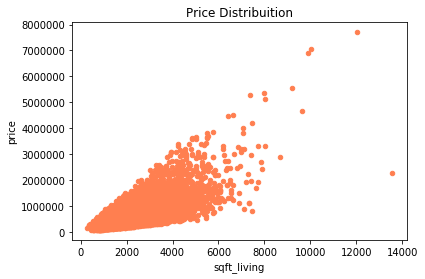

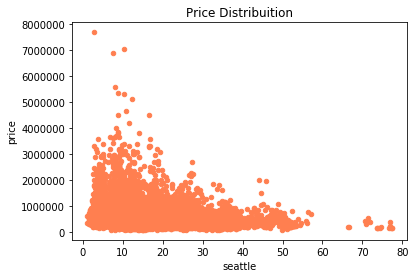

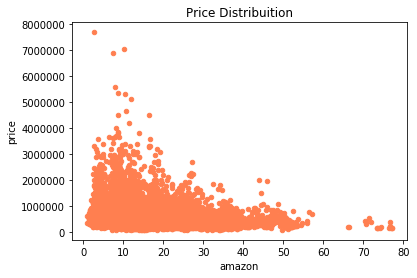

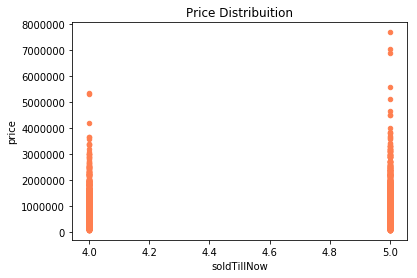

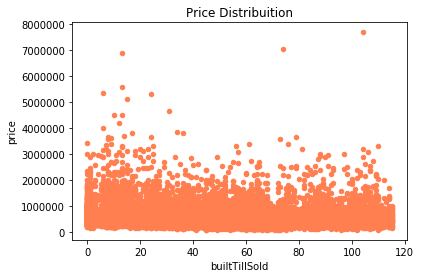

In [20]:
dfnew_local.plot(x='sqft_living', y='price', kind='scatter', color = 'coral')
plt.title('Price Distribuition')

dfnew_local.plot(x='seattle', y='price', kind='scatter', color = 'coral')
plt.title('Price Distribuition')

dfnew_local.plot(x='amazon', y='price', kind='scatter', color = 'coral')
plt.title('Price Distribuition')

dfnew_local.plot(x='soldTillNow', y='price', kind='scatter', color = 'coral')
plt.title('Price Distribuition')

dfnew_local.plot(x='builtTillSold', y='price', kind='scatter', color = 'coral')
plt.title('Price Distribuition')

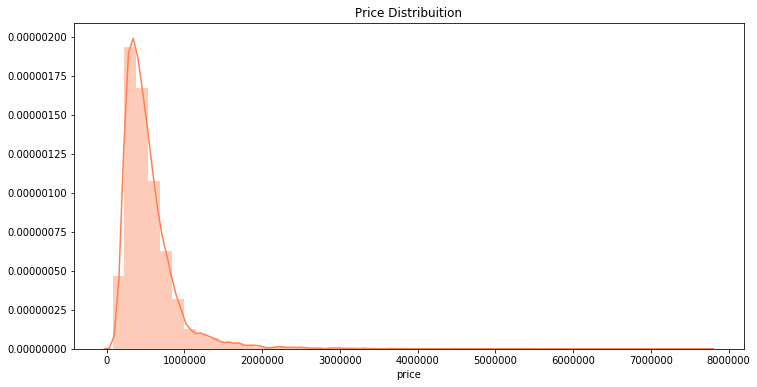

In [22]:
import seaborn as sns
plt.figure(figsize = (12, 6))

plt.title('Price Distribuition')
sns.distplot(dfnew_local['price'], color = 'coral')
plt.show()

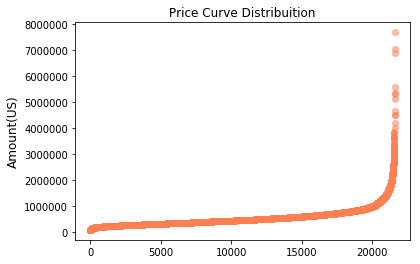

In [23]:
plt.scatter(range(dfnew_local.shape[0]), np.sort(dfnew_local.price.values), color = 'coral', alpha = 0.5)
plt.title("Price Curve Distribuition", fontsize=12)
plt.xlabel("")
plt.ylabel("Amount(US)", fontsize=12)
plt.show()

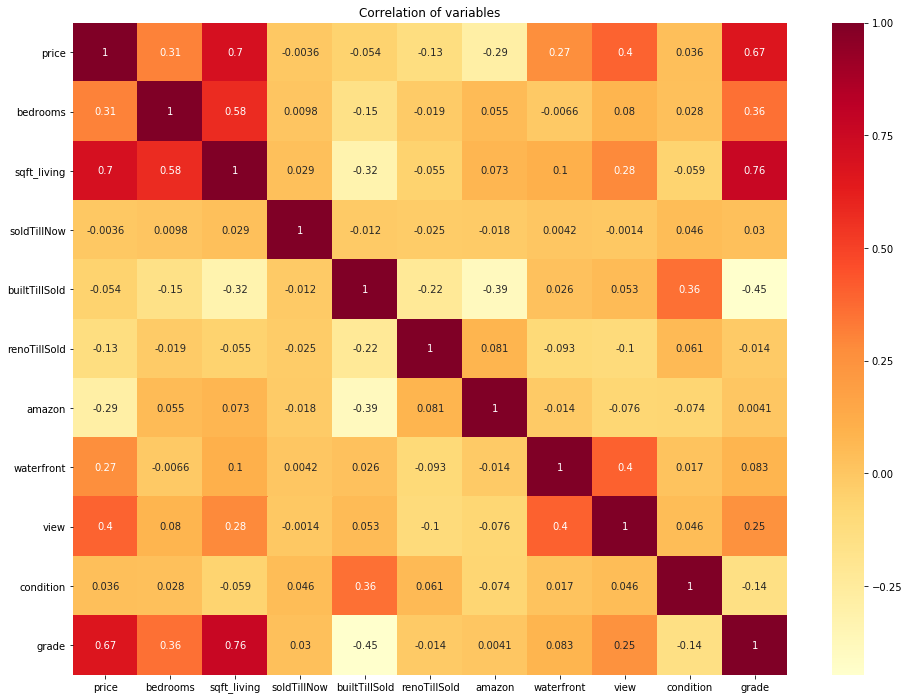

In [24]:
corr = dfnew_local[['price', 'bedrooms','sqft_living','soldTillNow', 'builtTillSold', 'renoTillSold', 
                    'amazon','waterfront', 'view', 'condition', 'grade']]

plt.figure(figsize=(16,12))
plt.title('Correlation of variables')
sns.heatmap(corr.astype(float).corr(), vmax= 1.0,  annot=True, cmap="YlOrRd")
plt.yticks(rotation=0)
plt.show()